In [5]:
!pip install lightgbm
!pip install seaborn

    100% |████████████████████████████████| 184kB 2.2MB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 12.6MB 1.5MB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 952kB 2.1MB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/6a/8a/718fd7d3458f9fab8e67186b00abdd345b639976bc7fb3ae722e1b026a50/pyparsing-2.2.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for seaborn ... done
  Stored in directory: /home/snake/.cache/pip/wheels/26/0a/44/53ddd89769e62f7c6691976375b86c6492e7dd20a2d3970e32
Successfully built seaborn


In [47]:
import os
import csv
import pandas as pd
import lightgbm as lgb
import numpy as np
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns

In [2]:
train_frame = pd.read_csv('../data/train.csv')
test_frame = pd.read_csv('../data/test.csv')

In [3]:
test_item_id = test_frame.item_id.values

In [4]:
cat_columns = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'user_type']
for col in cat_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train_frame[col].values.astype('str')) + list(test_frame[col].values.astype('str')))
    train_frame[col] = lbl.transform(list(train_frame[col].values.astype('str')))
    test_frame[col] = lbl.transform(list(test_frame[col].values.astype('str')))


In [5]:
train_x = train_frame[['price', 'image_top_1']].values
test_x = test_frame[['price', 'image_top_1']].values
train_arr = [train_x]
test_arr = [test_x]
for col in cat_columns:
    lbl = OneHotEncoder()
    lbl_set = list(train_frame[col].values) + list(test_frame[col].values)
    lbl_set = np.reshape(np.array(lbl_set), (-1, 1))
    lbl.fit(lbl_set)
    lbl_set_train = np.reshape(np.array(list(train_frame[col].values)), (-1, 1))
    train_col_lbl = lbl.transform(lbl_set_train)
    train_arr.append(train_col_lbl.todense())
    lbl_set_test = np.reshape(np.array(list(test_frame[col].values)), (-1, 1))
    test_col_lbl = lbl.transform(lbl_set_test)
    test_arr.append(test_col_lbl.todense())

In [11]:
from scipy.sparse import hstack
for item in train_arr:
    print(train_arr.shape)

AttributeError: 'list' object has no attribute 'shape'

In [12]:
train_x.shape

(1503424, 2)

In [9]:
train_x = hstack(train_arr)


ValueError: could not broadcast input array from shape (1503424,2) into shape (1503424)

In [13]:
test_x = hstack(test_arr)

ValueError: could not broadcast input array from shape (508438,2) into shape (508438)

In [14]:
print(train_x.shape)
print(test_x.shape)

(1503424, 2)
(508438, 2)


In [15]:
y = train_frame.deal_probability.values

In [16]:
del train_arr, test_arr, train_frame, test_frame

In [17]:
gc.collect()

224

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, y, test_size=0.2, random_state=42)


In [19]:
print(y_train)

[0.76786 0.      0.12311 ... 0.2     0.80323 0.     ]


In [20]:
lgtrain = lgb.Dataset(np.asarray(X_train), label=y_train)
lgval = lgb.Dataset(np.asarray(X_valid), label=y_valid)

In [21]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        'num_leaves': 250,
        'feature_fraction': 0.65,
        'bagging_fraction': 0.85,
        'learning_rate': 0.02,
    }
    
evals_result = {}
model = lgb.train(params, lgtrain, 4000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.254107
[40]	valid_0's rmse: 0.250664
[60]	valid_0's rmse: 0.248521
[80]	valid_0's rmse: 0.247141
[100]	valid_0's rmse: 0.246216
[120]	valid_0's rmse: 0.245569
[140]	valid_0's rmse: 0.245098
[160]	valid_0's rmse: 0.244741
[180]	valid_0's rmse: 0.244461
[200]	valid_0's rmse: 0.244234
[220]	valid_0's rmse: 0.244047
[240]	valid_0's rmse: 0.24389
[260]	valid_0's rmse: 0.243755
[280]	valid_0's rmse: 0.243639
[300]	valid_0's rmse: 0.243537
[320]	valid_0's rmse: 0.243448
[340]	valid_0's rmse: 0.243369
[360]	valid_0's rmse: 0.2433
[380]	valid_0's rmse: 0.243238
[400]	valid_0's rmse: 0.243183
[420]	valid_0's rmse: 0.243134
[440]	valid_0's rmse: 0.24309
[460]	valid_0's rmse: 0.24305
[480]	valid_0's rmse: 0.243015
[500]	valid_0's rmse: 0.242984
[520]	valid_0's rmse: 0.242956
[540]	valid_0's rmse: 0.242931
[560]	valid_0's rmse: 0.242908
[580]	valid_0's rmse: 0.242888
[600]	valid_0's rmse: 0.24287
[620]	valid_0's r

In [40]:
test_predictions = model.predict(np.asarray(test_x))

In [37]:
print(test_predictions.shape)

(508438,)


In [42]:
test_predictions[:100]

array([ 0.18999929,  0.23915158,  0.19538364,  0.21692625,  0.23409555,
        0.25220771,  0.14831401,  0.06866823,  0.12174806,  0.09126769,
        0.23162443,  0.14999584,  0.21018317,  0.06391904,  0.20970685,
        0.29559455,  0.07963735,  0.03493283,  0.04774289,  0.37654517,
        0.06168121,  0.15699316,  0.17082914,  0.03530208,  0.19569105,
        0.06501561,  0.10259724,  0.12227936,  0.02268997,  0.23322582,
        0.16575789, -0.03898808,  0.26293134,  0.24755942,  0.20800927,
        0.04553806,  0.21852173,  0.03870179,  0.21627921,  0.05235374,
        0.18613448,  0.15647021,  0.0808578 ,  0.03257453,  0.16962321,
        0.09863694,  0.24846602,  0.13353871,  0.31097337,  0.19432431,
        0.24843879,  0.23336633,  0.13449221,  0.14601945,  0.30273939,
        0.16431472,  0.07386099,  0.22295057,  0.2059613 ,  0.21119926,
        0.1313782 ,  0.07614371,  0.04342693,  0.04923538,  0.08380286,
        0.10152247,  0.24734356,  0.27245486,  0.04788829,  0.03

In [27]:
predictions[predictions > 0.2] = 1
predictions[predictions <= 0.2] = 0
predictions = predictions.astype(int)

In [46]:
sub_df = pd.DataFrame({"item_id":test_item_id})
sub_df["deal_probability"] = test_predictions.clip(0,1)
sub_df.to_csv("/tmp/baseline_avito.csv", index=False)

/home/snake/PycharmProjects/kaggle_competitions/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


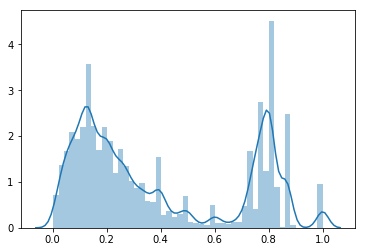

In [44]:
sns.distplot(y[y>0.001])

/home/snake/PycharmProjects/kaggle_competitions/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


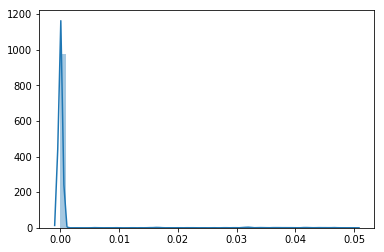

In [30]:
sns.distplot(y[y< 0.05])

/home/snake/PycharmProjects/kaggle_competitions/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


LinAlgError: singular matrix

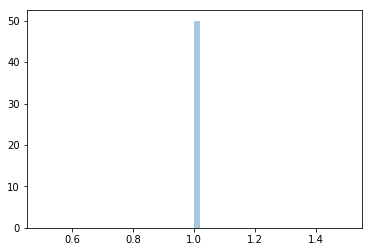

In [31]:
sns.distplot(y[y > 0.95])

/home/snake/PycharmProjects/kaggle_competitions/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


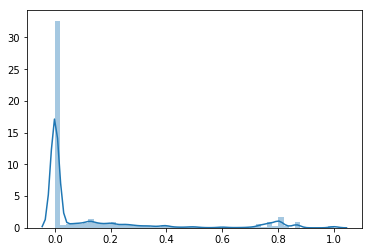

In [32]:
sns.distplot(y)